# Comparing Classification Algorithms

In [1]:
# In this project we are using classifiaction as a form of supervised leaning to predict clients response to a promotion campaign 
# Positive : 1 or Negative : 0
# Three supervised learning algorithms to be compared are: Logistic Regression, Decision Tree and Random Forests

# Importing relevant libraries
import numpy as np 
import pandas as pd
from sklearn.datasets import make_classification

#For visualization 
import matplotlib.pyplot as plt  
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
import seaborn as sns
%matplotlib inline

#For statistics
import math
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler as Scaler
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler 
scaler = StandardScaler() 

# The different algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier 

# Import the slearn utility to compare algorithms
from sklearn import model_selection,discriminant_analysis
from sklearn.model_selection import train_test_split 

In [2]:
#Importing response files 
response_data = pd.read_csv('data/Retail_Data_Response.csv')
response_data

,customer_id,response
0,CS1112,0
1,CS1113,0
2,CS1114,1
3,CS1115,1
4,CS1116,1
...,...,...
6879,CS8996,0
6880,CS8997,0
6881,CS8998,0
6882,CS8999,0


In [3]:
print('To better understand responses, only 9.40 % responded positively, data unbalanced')
print(' ')
response_data['response'].value_counts()

To better understand responses, only 9.40 % responded positively, data unbalanced
 


response
0    6237
1     647
Name: count, dtype: int64

 
### <span style='color:Orange'>1. Monthly and Annual Data </span>

In [4]:
# Annual Data
annual_features = pd.read_excel('data/annual_features.xlsx')
annual_day_of_week_counts_pivot= pd.read_excel('data/annual_day_of_week_counts_pivot.xlsx')

# Monthly Data
mth_rolling_features = pd.read_excel('data/mth_rolling_features.xlsx')
mth_day_counts = pd.read_excel('data/mth_day_counts.xlsx')
days_since_last_txn = pd.read_excel('data/days_since_last_txn.xlsx')


# Annual feature outputs
annual_features_outputs = annual_features.merge(annual_day_of_week_counts_pivot)
annual_features_outputs = annual_features_outputs.merge(response_data)


# Monthly feature outputs
# Organising data 
mth_rolling_features1 = mth_rolling_features.drop(['Unnamed: 0'], axis = 1)
mth_day_counts = mth_day_counts.sort_values(by = ['CLNT_NO','ME_DT'])
mth_day_counts1 = mth_day_counts.drop(['Unnamed: 0'], axis = 1)
days_since_last_txn1 = days_since_last_txn.drop(['Unnamed: 0'], axis =1)

# Changing column name in response data to make merging easy 
response_data1 = response_data.rename(columns = {'customer_id':'CLNT_NO'})

monthly_features_outputs = mth_rolling_features1.merge(mth_day_counts1)
monthly_features_outputs = monthly_features_outputs.merge(days_since_last_txn1)
monthly_features_outputs = monthly_features_outputs.merge(response_data1)
monthly_features_outputs = monthly_features_outputs.fillna(0)


### <span style='color:Orange'> 2. Fitting to Classification Models </span>

#### Standardizing and Separating Annual and Monthly Data Into Training and Testing Sets 

In [5]:
# To better understand the distribution of data, if it needs to be standardised
print(annual_features_outputs.max())
print(monthly_features_outputs.max())

customer_id             CS9000
ann_txn_amt_sum_2011       849
ann_txn_amt_sum_2012      1242
ann_txn_amt_sum_2013      1317
ann_txn_amt_sum_2014      1029
                         ...  
cnt_2015_Sunday              3
cnt_2015_Thursday            3
cnt_2015_Tuesday             3
cnt_2015_Wednesday           3
response                     1
Length: 77, dtype: object
CLNT_NO                             CS5111
ME_DT                  2015-03-31 00:00:00
mth_txn_amt_sum                        460
mth_txn_cnt                              6
amt_sum_3M                           900.0
amt_mean_3M                          300.0
amt_max_3M                           460.0
txn_cnt_sum_3M                        13.0
txn_cnt_mean_3M                   4.333333
txn_cnt_max_3M                         6.0
amt_sum_6M                          1258.0
amt_mean_6M                     209.666667
amt_max_6M                           460.0
txn_cnt_sum_6M                        18.0
txn_cnt_mean_6M                

##### Note: For Logistic Regression standardisation is required to avoid enormous numerical problems

In [6]:
# Separating X and y values, Annual data
y_annual= annual_features_outputs['response'].values

# Dropping response,Customer ID and strings 
X_annual = annual_features_outputs.drop(['response','customer_id'], axis = 1).values

# Yearly train test data 
X_train_annual, X_test_annual, y_train_annual, y_test_annual = train_test_split(X_annual, y_annual, test_size= 2/3, random_state=1147)

# Standardising X values 
X_train_annual_scaled = scaler.fit_transform(X_train_annual)
X_test_annual_scaled = scaler.fit_transform(X_test_annual)

# Separating X and y values, Monthly data
y_monthly = monthly_features_outputs['response'].values

# Dropping strings i.e Client No and Dates and response
X_monthly = monthly_features_outputs.drop(['response','ME_DT','CLNT_NO'], axis = 1).values

# Monthly train test data 
X_train_monthly, X_test_monthly, y_train_monthly, y_test_monthly = train_test_split(X_monthly, y_monthly, test_size= 2/3, random_state=1147)

# Standardising X values 
X_train_monthly_scaled = scaler.fit_transform(X_train_monthly)
X_test_monthly_scaled = scaler.fit_transform(X_test_monthly)



### <span style='color:Green'> Method  1 : Logistic Regression with L1 Regularization </span>

####  <span style='color:Blue'> Annual data </span> 

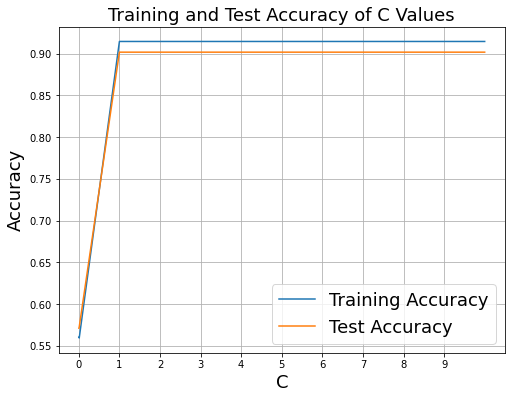

In [7]:
#Fitting the training dataset and optimize the hyperparameters of the method

## L1 regularization is used as it is useful for feature selection, it can automatically identify and remove unnecessary features from the model.
## Liblinear solver also used as this is a relatively small dataset and binary classification
   
C_annual = [ 10, 1, .01, .001] #parameter
training_accuracy = []
test_accuracy = []

for c in C_annual:
    logreg_annual= LogisticRegression(penalty='l1', C = c, solver='liblinear')
    logreg_annual.fit(X_train_annual, y_train_annual)
    training_accuracy.append(logreg_annual.score(X_train_annual_scaled, y_train_annual))
    test_accuracy.append(logreg_annual.score(X_test_annual_scaled, y_test_annual))
    

plt.figure(figsize=(8, 6))
plt.title("Training and Test Accuracy of C Values", fontsize = 18)
plt.plot(C_annual,training_accuracy, label = 'Training Accuracy')
plt.plot(C_annual,test_accuracy, label = 'Test Accuracy')
plt.ylabel('Accuracy', fontsize = 18)
plt.xlabel('C', fontsize = 18)
plt.xticks(np.arange(0, 10, step=1))
plt.grid()
plt.legend( fontsize = 18)
plt.show()



C_annual:1 

Intercept b: [-5.509181] 

Training accuracy: 0.9145597210113339
Test accuracy: 0.9017429193899782


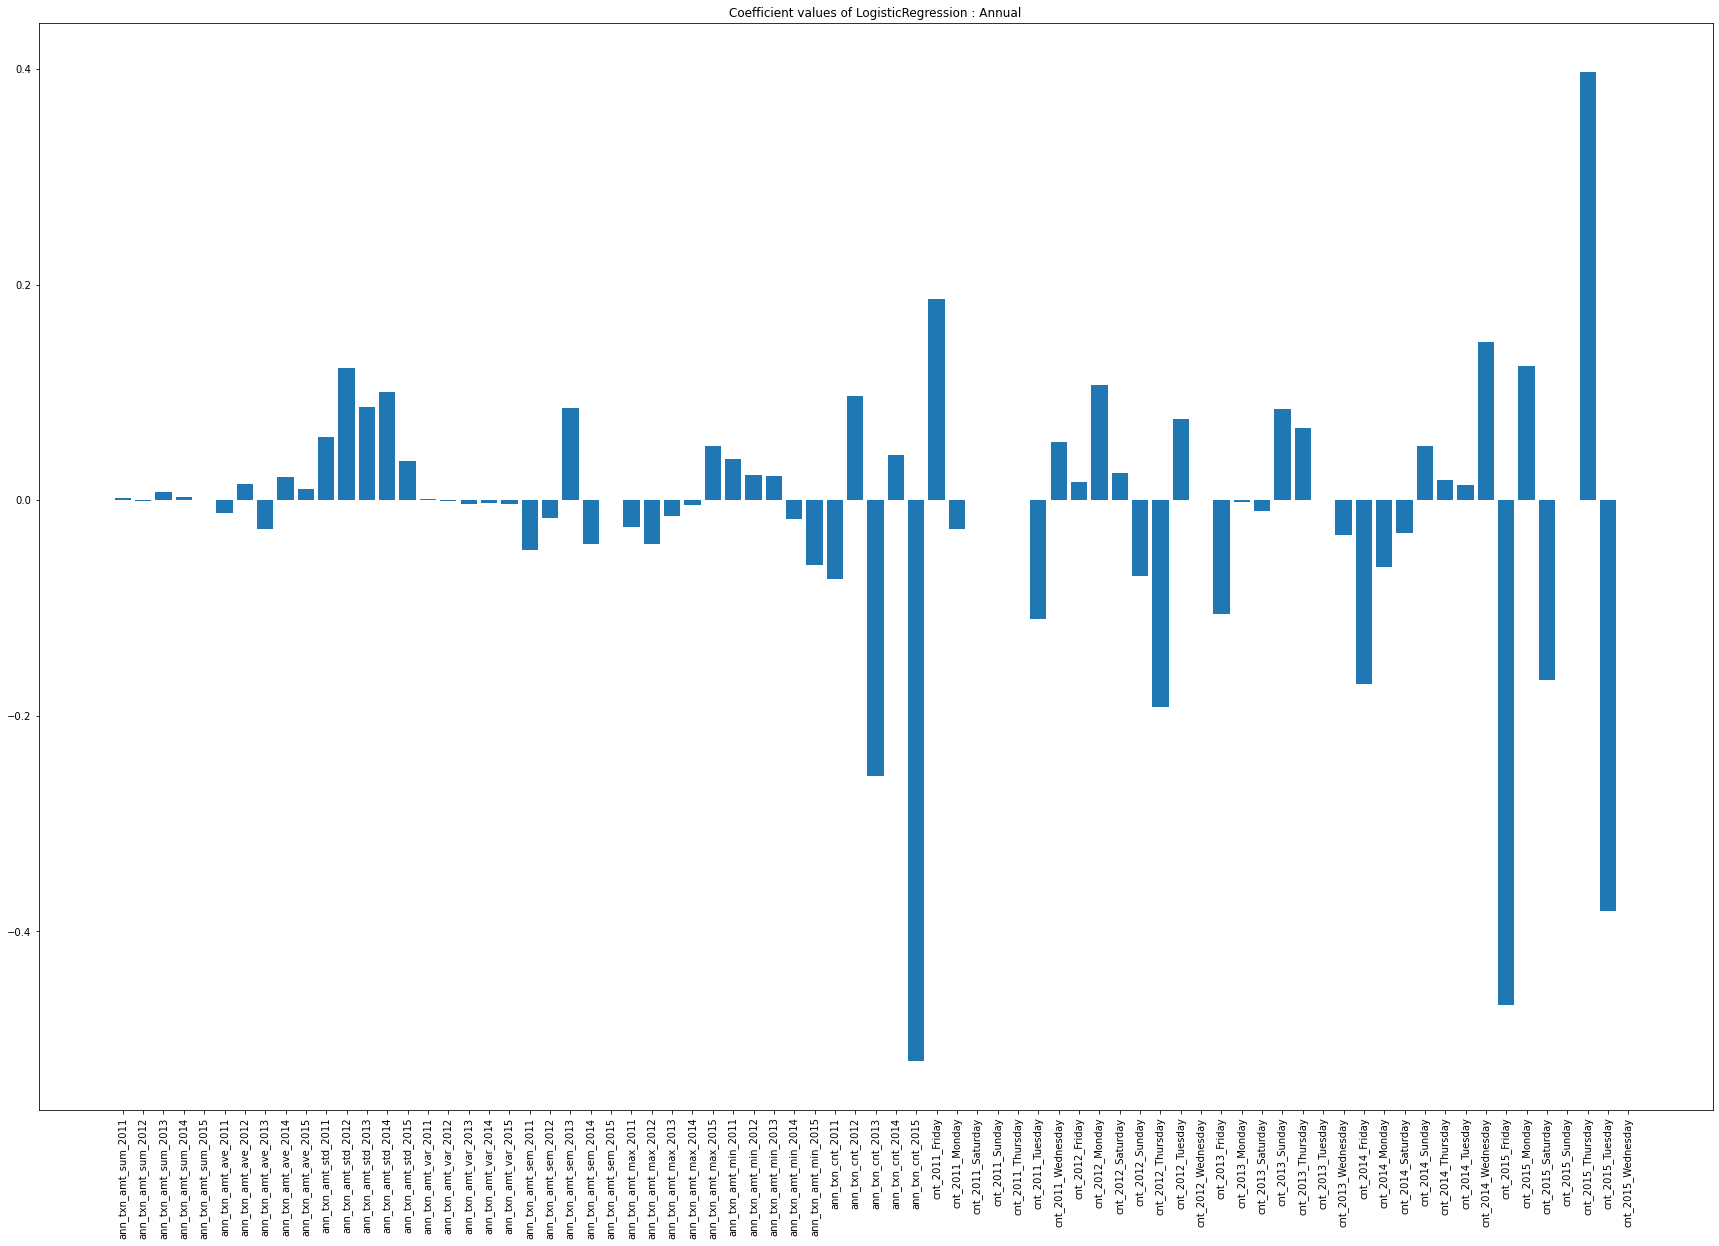

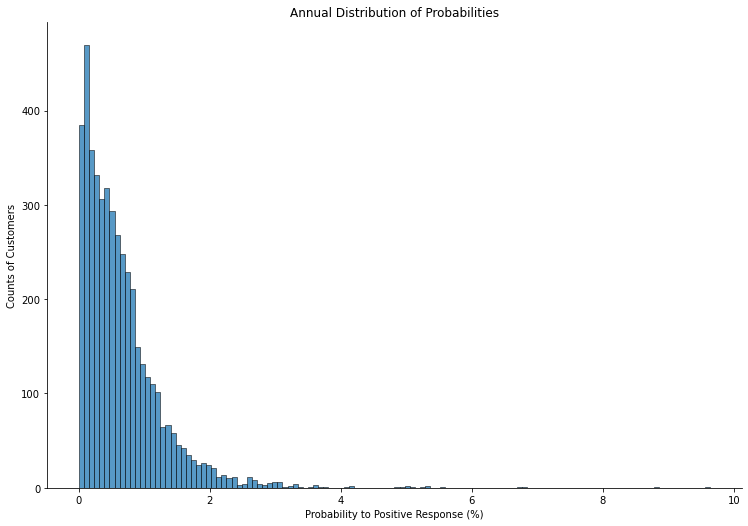

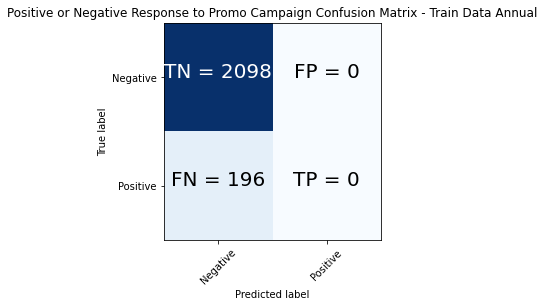

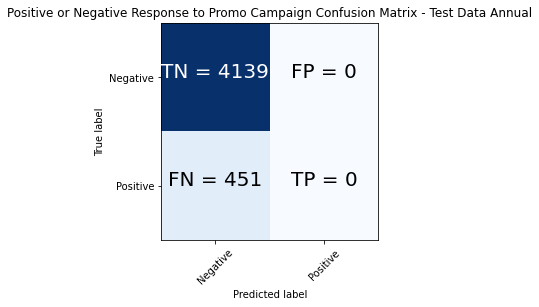

It is important to remember that this is an inbalanced dataset,explaning the zeros in the confusion matrix 

              precision    recall  f1-score   support

    Positive       0.90      1.00      0.95      4139
    Negative       0.00      0.00      0.00       451

    accuracy                           0.90      4590
   macro avg       0.45      0.50      0.47      4590
weighted avg       0.81      0.90      0.86      4590



/Users/portiamasibi/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/portiamasibi/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/portiamasibi/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

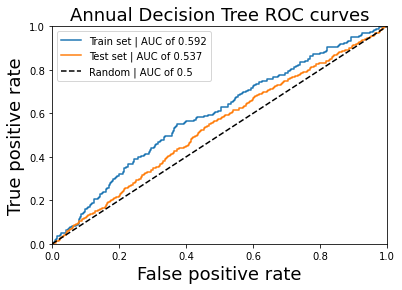

In [11]:
# Therefore C_annual = 1 as training and test accuracy is high. 
# Although C is high and leads to a weaker regulariation,i.e a more complex model, this is the lowest value we can use.

# Fitting Model 
logreg_annual= LogisticRegression(penalty='l1',C = 1, solver='liblinear')
logreg_annual.fit(X_train_annual, y_train_annual)
print('C_annual:1 \n')
print('Intercept b:', logreg_annual.intercept_, '\n')
print('Training accuracy:', logreg_annual.score(X_train_annual_scaled, y_train_annual))
print('Test accuracy:', logreg_annual.score(X_test_annual_scaled, y_test_annual))


 # Plotting coefficient values or feature importance
plt.figure(figsize=(30, 20))
plt.title("Coefficient values of LogisticRegression : Annual")
plt.bar(range(X_annual.shape[1]), logreg_annual.coef_[0])
plt.xticks(range(X_annual.shape[1]), annual_features_outputs.columns[1:-1], rotation=90)
plt.show()


 # Plotting probability distribution for test set
y_test_annual_proba = logreg_annual.predict_proba(X_test_annual_scaled)
sns.displot(data = y_test_annual_proba [:,1], x = 100*y_test_annual_proba [:,1], height = 7, aspect = 1.5)
plt.title('Annual Distribution of Probabilities')
plt.xlabel('Probability to Positive Response (%)')
plt.ylabel('Counts of Customers')
plt.show()



# Plotting confusion matrix and ROC curves of train/test set & Calculating precision/recall

#Confusion matrix: Train Data
y_train_annual_predicted = logreg_annual.predict(X_train_annual_scaled)
cm_annual = confusion_matrix(y_train_annual, y_train_annual_predicted)
plt.clf()
plt.imshow(cm_annual, interpolation='nearest', cmap=plt.cm.Blues)
classNames = ['Negative','Positive']
plt.title('Positive or Negative Response to Promo Campaign Confusion Matrix - Train Data Annual')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
thresh = math.floor(cm_annual.max() / 2.)
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm_annual[i][j]), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm_annual[i, j] > thresh else "black")
plt.show()
   
        

# Confusion matrix: Test Data
y_test_annual_predicted = logreg_annual.predict(X_test_annual_scaled)
cm_annual = confusion_matrix(y_test_annual, y_test_annual_predicted)
plt.clf()
plt.imshow(cm_annual, interpolation='nearest', cmap=plt.cm.Blues)
classNames = ['Negative','Positive']
plt.title('Positive or Negative Response to Promo Campaign Confusion Matrix - Test Data Annual')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
thresh = math.floor(cm_annual.max() / 2.)
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm_annual[i][j]), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm_annual[i, j] > thresh else "black")
plt.show()


# Precision and Recall
print('It is important to remember that this is an inbalanced dataset,explaning the zeros in the confusion matrix \n')
print(classification_report(y_test_annual, y_test_annual_predicted, target_names = ['Positive', 'Negative']))


# ROC Curve - much more useful to compare models especially in unbalanced datasets

# Scores 
annual_scores_train = logreg_annual.predict_proba(X_train_annual_scaled)[:, 1]
annual_scores_test = logreg_annual.predict_proba(X_test_annual_scaled)[:, 1]

# ROC Calc 
fpr_train_annual, tpr_train_annual, _ = roc_curve(y_train_annual, annual_scores_train)
fpr_test_annual, tpr_test_annual, _ = roc_curve(y_test_annual, annual_scores_test)

# AUC Calc
auc_train_annual = auc(fpr_train_annual, tpr_train_annual)
auc_test_annual  = auc(fpr_test_annual, tpr_test_annual)

# Plotting
plt.plot(fpr_train_annual, tpr_train_annual, label='Train set | AUC of {:4.3f}'.format(auc_train_annual));
plt.plot(fpr_test_annual, tpr_test_annual, label='Test set | AUC of {:4.3f}'.format(auc_test_annual));
plt.plot([0,1], [0,1], color = 'k', linestyle = '--', label = 'Random | AUC of 0.5');
plt.ylim([0,1.0])
plt.xlim([0,1.0])
plt.title('Annual Decision Tree ROC curves', fontsize = 18)
plt.ylabel('True positive rate', fontsize = 18)
plt.xlabel('False positive rate', fontsize = 18)
plt.legend()
plt.show()


####  <span style='color:Blue'> Monthly data </span> 

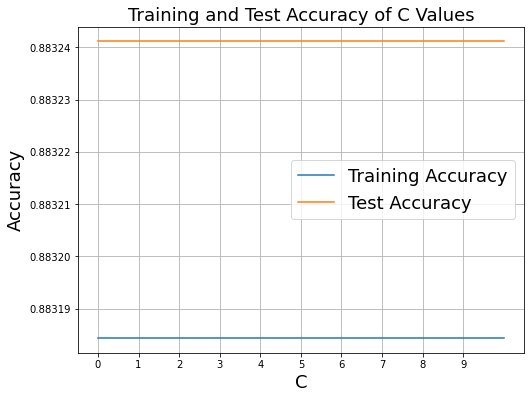

In [ ]:
# 2.4 Fitting the training dataset and optimize the hyperparameters of the method

C_monthly = [10, 1, .01, .001]    
training_accuracy = []
test_accuracy = []   
for c in C_monthly:
    logreg_monthly= LogisticRegression(penalty='l1', C = c, solver='liblinear')
    logreg_monthly.fit(X_train_monthly, y_train_monthly)
    training_accuracy.append(logreg_monthly.score(X_train_monthly_scaled, y_train_monthly))
    test_accuracy.append(logreg_monthly.score(X_test_monthly_scaled, y_test_monthly))

plt.figure(figsize=(8, 6))
plt.title("Training and Test Accuracy of C Values", fontsize = 18)
plt.plot(C_monthly,training_accuracy, label = 'Training Accuracy')
plt.plot(C_monthly,test_accuracy, label = 'Test Accuracy')
plt.ylabel('Accuracy', fontsize = 18)
plt.xlabel('C', fontsize = 18)
plt.xticks(np.arange(0, 10, step=1))
plt.grid()
plt.legend( fontsize = 18)
plt.show()



C_monthly: 1 

Intercept b: [-2.07791614] 

Training accuracy: 0.8831843971631206
Test accuracy: 0.883241134751773


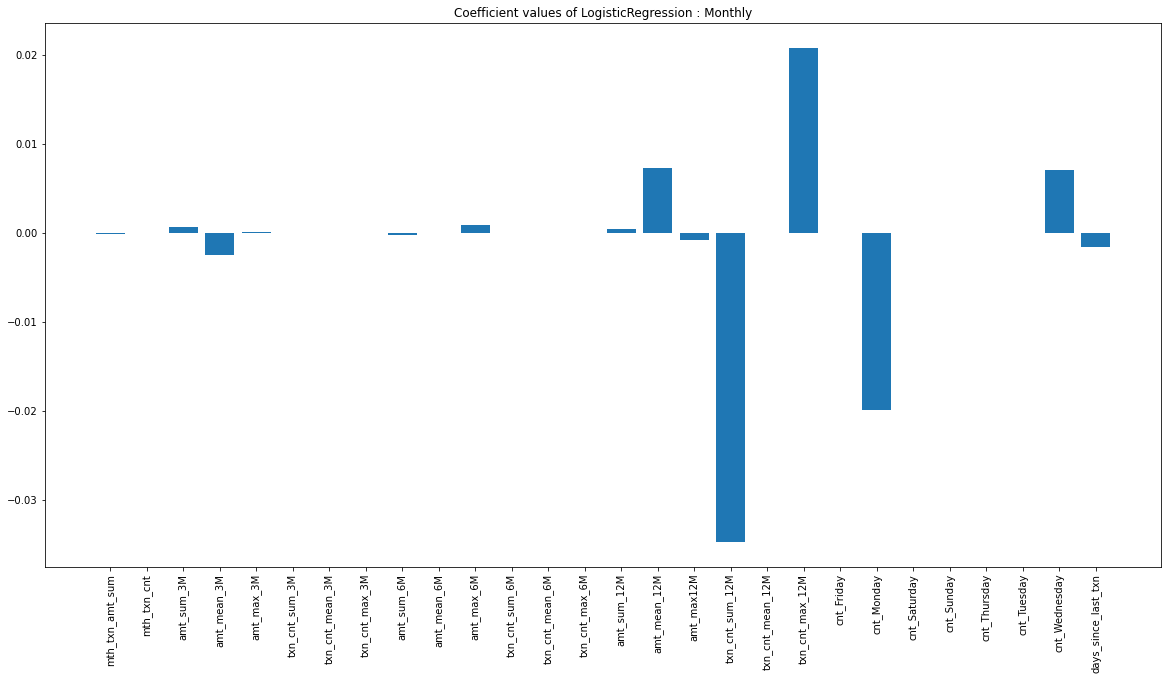

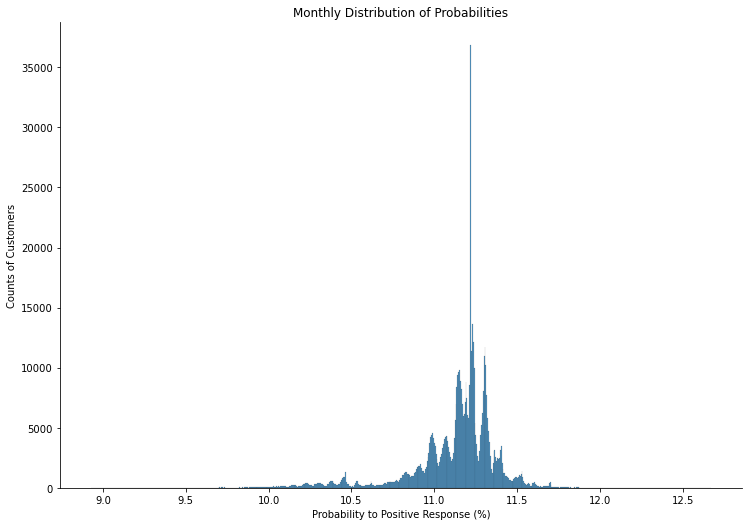

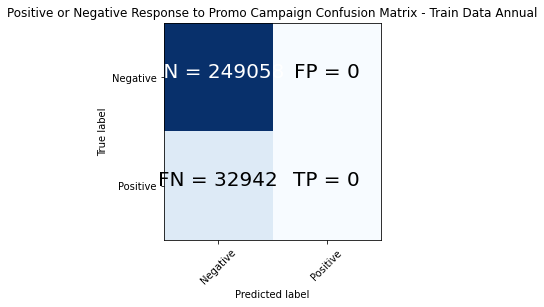

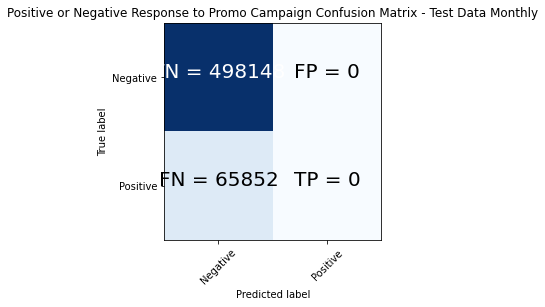

/Users/portiamasibi/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/portiamasibi/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/portiamasibi/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

              precision    recall  f1-score   support

    Positive       0.88      1.00      0.94    498148
    Negative       0.00      0.00      0.00     65852

    accuracy                           0.88    564000
   macro avg       0.44      0.50      0.47    564000
weighted avg       0.78      0.88      0.83    564000



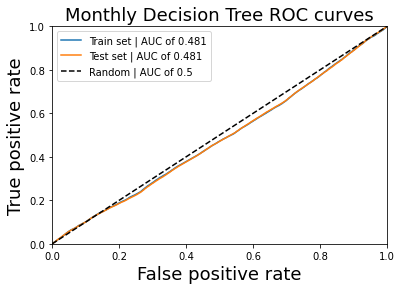

In [15]:
# Therefore C_monthly = 0.01 ,Training and Testing accuracy high and stops changing and for stronger regularization, model less complex

#Fitting model 
    
logreg_monthly = LogisticRegression(penalty='l1' ,C = 0.01, solver='liblinear') 
logreg_monthly.fit(X_train_monthly, y_train_monthly)
print('C_monthly: 1 \n')
print('Intercept b:', logreg_monthly.intercept_,'\n')
print('Training accuracy:', logreg_monthly.score(X_train_monthly_scaled, y_train_monthly))
print('Test accuracy:', logreg_monthly.score(X_test_monthly_scaled, y_test_monthly))


# 2.5 Plotting coefficient values or feature importance
# Create plot
plt.figure(figsize=(20, 10))
# Create plot title
plt.title("Coefficient values of LogisticRegression : Monthly")
# Add bars
plt.bar(range(X_monthly.shape[1]), logreg_monthly.coef_[0])
# Add feature names as x-axis labels
plt.xticks(range(X_monthly.shape[1]), monthly_features_outputs.columns[2:-1], rotation=90)
# Show plot
plt.show()


 # 2.6 Plotting probability distribution for test set

y_test_monthly_proba = logreg_monthly.predict_proba(X_test_monthly_scaled)
sns.displot(data = y_test_monthly_proba [:,1], x = 100*y_test_monthly_proba [:,1], height = 7, aspect = 1.5)
plt.title('Monthly Distribution of Probabilities')
plt.xlabel('Probability to Positive Response (%)')
plt.ylabel('Counts of Customers')
plt.show()


 # 2.7 Plotting confusion matrix and ROC curves of train/test set & Calculating precision/recall

#Confusion matrix: Train Data
y_train_monthly_predicted = logreg_monthly.predict(X_train_monthly_scaled)
cm_monthly = confusion_matrix(y_train_monthly, y_train_monthly_predicted)
plt.clf()
plt.imshow(cm_monthly, interpolation='nearest', cmap=plt.cm.Blues)
classNames = ['Negative','Positive']
plt.title('Positive or Negative Response to Promo Campaign Confusion Matrix - Train Data Annual')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
thresh = cm_monthly.max() / 2.
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm_monthly[i][j]), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm_monthly[i, j] > thresh else "black")
plt.show()
   


# Confusion matrix Test Data
y_test_monthly_predicted = logreg_monthly.predict(X_test_monthly_scaled)
cm_monthly = confusion_matrix(y_test_monthly, y_test_monthly_predicted)
plt.clf()
plt.imshow(cm_monthly, interpolation='nearest', cmap=plt.cm.Blues)
classNames = ['Negative','Positive']
plt.title('Positive or Negative Response to Promo Campaign Confusion Matrix - Test Data Monthly')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
thresh = cm_monthly.max() / 2.
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm_monthly[i][j]), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm_monthly[i, j] > thresh else "black")
plt.show()


# Precision and Recall
print(classification_report(y_test_monthly, y_test_monthly_predicted, target_names = ['Positive', 'Negative']))


# ROC Curve

# Scores for train set
monthly_scores_train = logreg_monthly.predict_proba(X_train_monthly_scaled)[:, 1]
# Scores for test set
monthly_scores_test = logreg_monthly.predict_proba(X_test_monthly_scaled)[:, 1]

# ROC Calc Train set
fpr_train_monthly, tpr_train_monthly, _ = roc_curve(y_train_monthly, monthly_scores_train)
# ROC Calc Test set
fpr_test_monthly, tpr_test_monthly, _ = roc_curve(y_test_monthly, monthly_scores_test)
# AUC Calc
auc_train_monthly = auc(fpr_train_monthly, tpr_train_monthly)
# AUC Calc
auc_test_monthly  = auc(fpr_test_monthly, tpr_test_monthly)

# Plotting
plt.plot(fpr_train_monthly, tpr_train_monthly, label='Train set | AUC of {:4.3f}'.format(auc_train_monthly));
plt.plot(fpr_test_monthly, tpr_test_monthly, label='Test set | AUC of {:4.3f}'.format(auc_test_monthly));
plt.plot([0,1], [0,1], color = 'k', linestyle = '--', label = 'Random | AUC of 0.5');
plt.ylim([0,1.0])
plt.xlim([0,1.0])
plt.title('Monthly Decision Tree ROC curves', fontsize = 18)
plt.ylabel('True positive rate', fontsize = 18)
plt.xlabel('False positive rate', fontsize = 18)
plt.legend()
plt.show()




### <span style='color:Green'> Method 2 : Decision Tree </span>

####  <span style='color:Blue'> Annual data </span> 

In [18]:
#2.4 Fitting the training dataset and optimize the hyperparameters of the method
    
# Initiate some parameters that to track in the iteration below
max_depth_range = range(1, 12)
estimator_max_depth = []
accuracy_normalized = []
auc_train           = []
auc_test            = []

for i in max_depth_range:
    # Define and fit
    estimator_max_depth.append(DecisionTreeClassifier(random_state=0, max_depth = i))
    estimator_max_depth[i-1].fit(X_train_annual, y_train_annual)
    # Score train and test set,we don't need to store this in every iteration so we can overwrite it 
    scores_train = estimator_max_depth[i-1].predict_proba(X_train_annual)[:,1] 
    scores_test  = estimator_max_depth[i-1].predict_proba(X_test_annual)[:,1]  
    # Predict the class of test set
    y_test_predicted_annual = estimator_max_depth[i-1].predict(X_test_annual)
    # Calculate accuracy at every iteration and append
    accuracy_normalized.append(100*accuracy_score(y_test_annual, y_test_predicted_annual, normalize = True))
    # ROC Calc Train set,we don't need to store this in every iteration so we can overwrite it
    fpr_train, tpr_train, _ = roc_curve(y_train_annual, scores_train)
    # ROC Calc Test set,we don't need to store this in every iteration so we can overwrite it
    fpr_test, tpr_test, _ = roc_curve(y_test_annual, scores_test)
    # Calculate the AUCs
    auc_train.append(auc(fpr_train, tpr_train))
    auc_test.append(auc(fpr_test, tpr_test))
    
    
performance_dictionary = {'ACCURACY': accuracy_normalized, 
                          'AUC_TRAIN': auc_train,
                          'AUC_TEST': auc_test}
performance_df = pd.DataFrame(performance_dictionary)
performance_df['MAX_DEPTH'] = performance_df.index + 2
performance_df



,ACCURACY,AUC_TRAIN,AUC_TEST,MAX_DEPTH
0,90.174292,0.700504,0.678205,2
1,90.174292,0.736396,0.697802,3
2,90.174292,0.762659,0.704718,4
3,89.455338,0.792137,0.721851,5
4,89.324619,0.835297,0.725936,6
5,89.215686,0.870947,0.682999,7
6,87.908497,0.896951,0.696602,8
7,87.843137,0.922038,0.690663,9
8,87.429194,0.938444,0.688797,10
9,86.405229,0.954867,0.681136,11


AttributeError: 'SubplotSpec' object has no attribute 'is_first_col'

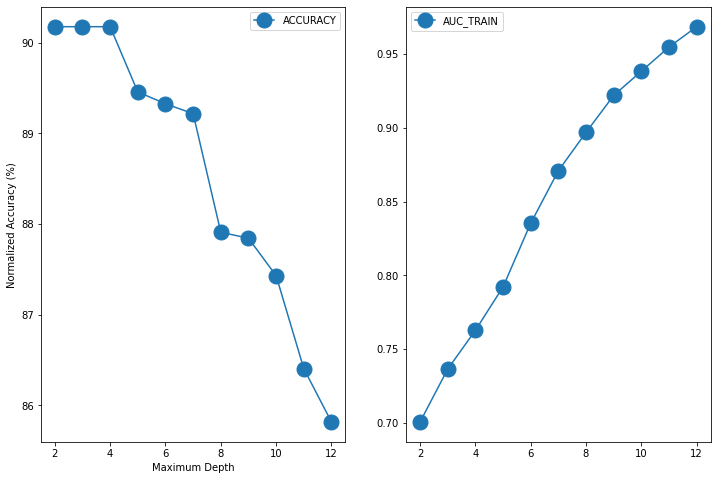

In [19]:
fig_1 = plt.figure(figsize=(12,8))

fig_1_a = plt.subplot(121)
ax1 = performance_df.plot(x = 'MAX_DEPTH', y = 'ACCURACY', ax = fig_1_a, style = 'o-', markersize =15)
ax1.set_ylabel("Normalized Accuracy (%)")
ax1.set_xlabel("Maximum Depth")

fig_1_b = plt.subplot(122)
ax2 = performance_df.plot(x = 'MAX_DEPTH', y = 'AUC_TRAIN', ax = fig_1_b, style = 'o-', markersize =15)
ax2 = performance_df.plot(x = 'MAX_DEPTH', y = 'AUC_TEST', ax = fig_1_b, style = 'o-', markersize =15)
ax2.set_xlabel("Maximum Depth")
ax2.set_ylabel("Area Under the Curve (AUC)")

plt.show()

#### Therefore Max Depth = 4, accuracy still high and AUC Train (76%) vs Test(70%) difference not too much 

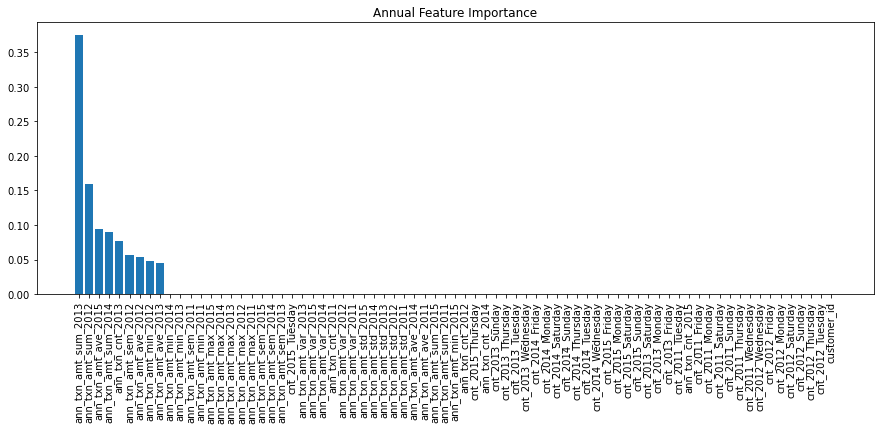

<Figure size 360x360 with 0 Axes>

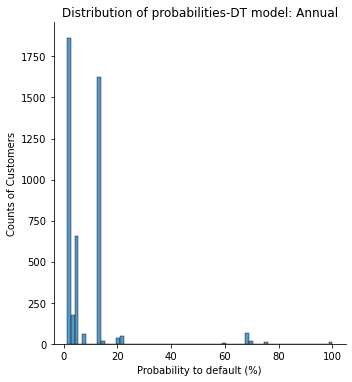

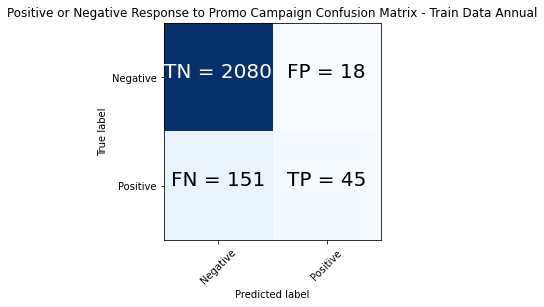

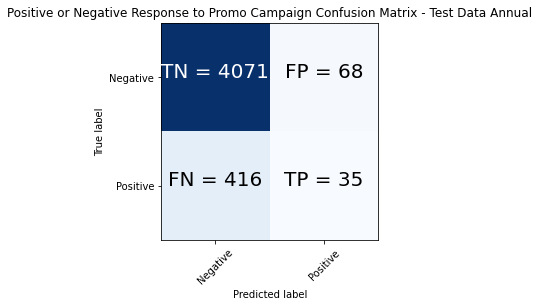

              precision    recall  f1-score   support

    Positive       0.91      0.98      0.94      4139
    Negative       0.34      0.08      0.13       451

    accuracy                           0.89      4590
   macro avg       0.62      0.53      0.54      4590
weighted avg       0.85      0.89      0.86      4590



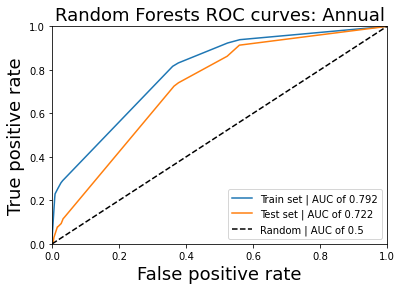

In [21]:
 #Fitting model 

# Define and fit
estimator = DecisionTreeClassifier(random_state=0, max_depth = 4)
dtc_best_model = estimator.fit(X_train_annual, y_train_annual)
scores_train = dtc_best_model.predict_proba(X_train_annual)[:,1] 
scores_test  = dtc_best_model.predict_proba(X_test_annual)[:,1]  

# Predict the class of test set
y_test_predicted = dtc_best_model.predict(X_test_annual)
y_train_predicted = dtc_best_model.predict(X_train_annual)
                                         
accuracy = 100*accuracy_score(y_test_annual, y_test_predicted, normalize = True)
                                         
# ROC Calc 
fpr_train, tpr_train, _ = roc_curve(y_train_annual, scores_train)
fpr_test, tpr_test, _ = roc_curve(y_test_annual, scores_test)
                                         
# Calculate the AUCs
auc_train = auc(fpr_train, tpr_train)
auc_test  = auc(fpr_test, tpr_test)



# 2.5 Plotting coefficient values or feature importance
        
importances = dtc_best_model.feature_importances_
# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [annual_features_outputs.columns[i] for i in indices] 

# Create plot
plt.figure(figsize=(15,5))
# Create plot title
plt.title("Annual Feature Importance")
# Add bars
plt.bar(range(X_annual.shape[1]), importances[indices])
# Add feature names as x-axis labels
plt.xticks(range(X_annual.shape[1]), names, rotation=90)
# Show plot
plt.show()




 # 2.6 Plotting probability distribution for test set.

plt.figure(figsize=(5,5))
sns.displot(data = scores_test, x = 100*scores_test)
plt.title('Distribution of probabilities-DT model: Annual')
plt.xlabel('Probability to default (%)')
plt.ylabel('Counts of Customers')
plt.show()


# 2.7 Plotting confusion matrix and ROC curves of train/test set & Calculating precision/recall.

# Confusion matrix :Train
cm= confusion_matrix(y_train_annual, y_train_predicted)
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
classNames = ['Negative','Positive']
plt.title('Positive or Negative Response to Promo Campaign Confusion Matrix - Train Data Annual')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
thresh = cm.max() / 2.
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.show()


# Confusion matrix :Test
cm= confusion_matrix(y_test_annual, y_test_predicted)
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
classNames = ['Negative','Positive']
plt.title('Positive or Negative Response to Promo Campaign Confusion Matrix - Test Data Annual')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
thresh = cm.max() / 2.
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.show()


# Precision and Recall
print(classification_report(y_test_annual, y_test_predicted, target_names = ['Positive', 'Negative']))

# ROC Curve
plt.plot(fpr_train, tpr_train, label='Train set | AUC of {:4.3f}'.format(auc_train));
plt.plot(fpr_test, tpr_test, label='Test set | AUC of {:4.3f}'.format(auc_test));
plt.plot([0,1], [0,1], color = 'k', linestyle = '--', label = 'Random | AUC of 0.5');
plt.ylim([0,1.0])
plt.xlim([0,1.0])
plt.title('Random Forests ROC curves: Annual', fontsize = 18)
plt.ylabel('True positive rate', fontsize = 18)
plt.xlabel('False positive rate', fontsize = 18)
plt.legend()
plt.show()



# # 2.8  Plotting decision boundary for top 2 features.


# # The importances with the highest values are "ann_txn_amt_sum_2012" and "ann_txn_amt_sum_2013" 

# # Limits: Max @ "ann_txn_sum_2012": 1242 and "ann_txn_sum_2013: 1317" 
# f1_max = math.ceil(X_train_annual.max(axis=0)[1] )
# f2_max = math.ceil(X_train_annual.max(axis=0)[2] )

# # Limits: Min @ "ann_txn_sum_2012": 0 and "ann_txn_sum_2013: 0" 
# f1_min = math.floor(X_train_annual.min(axis=0)[1])
# f2_min = math.floor(X_train_annual.min(axis=0)[2])


# #Creating a 10x10 grid between the min and max values that we will use to estimate the probabilities for the contour plot.
# xx, yy = np.mgrid[f1_min:f1_max:(f1_max-f1_min)/10, f2_min:f2_max:(f2_max-f2_min)/10] # A 10x10 grid is created
# grid = np.c_[xx.ravel(), yy.ravel()]
# print(grid.shape) # Confirm that grid shape is 10x10

# # np.ones is a table full of ones with 100x75 dimension
# # np.median calculates the median of every column in the X_train along axis=0 (i.e. column)
# median_inputs = np.ones((100, 75)) * np.median(X_train_annual, axis=0) 
# pd.DataFrame(median_inputs) # Convert to pandas is not necessary. Just doing it here to have a nice view of the table

# # Then, we replace the 39th and 68th column with the values of the grid
# median_inputs[:,1] = grid[:,0]
# median_inputs[:,2] = grid[:,1]
# df = pd.DataFrame(median_inputs).iloc[:12,0:5] # Convert to pandas is not necessary. 
# df.style.apply(lambda x: ['background: grey' if (x.name == 1)|(x.name == 2)  else '' for i in x])

# probs =  dtc_best_model.predict_proba(median_inputs)[:, 1].reshape(xx.shape)

# f, ax = plt.subplots(figsize=(8, 6))
# contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
#                       vmin=0, vmax=1)
# ax_c = f.colorbar(contour)
# ax_c.set_label("$P(y = 1)$")
# #ax_c.set_ticks([0, .25, .5, .75, 1])

# ax.scatter(X_train_annual[:,1], X_train_annual[:, 2], c=y_train_annual, s=50,cmap="RdBu", vmin=-.2, vmax=1.2,
#            edgecolor="white", linewidth=1)

# ax.set(aspect="auto",
#        xlim=(0, 1120), ylim=(0, 1190),
#        xlabel="ann_txn_amt_sum_2012", ylabel="ann_txn_amt_sum_2013")
    
# plt.show() 
    
    

####  <span style='color:Blue'> Monthly data </span> 

In [22]:

#2.4 Fitting the training dataset and optimize the hyperparameters of the method
    
# Initiate some parameters that to track in the iteration below
max_depth_range = range(1, 25)
estimator_max_depth = []
accuracy_normalized = []
auc_train           = []
auc_test            = []

for i in max_depth_range:
    # Define and fit
    estimator_max_depth.append(DecisionTreeClassifier(random_state=0, max_depth = i))
    estimator_max_depth[i-1].fit(X_train_monthly, y_train_monthly)
    # Score train and test set,we don't need to store this in every iteration so we can overwrite it 
    scores_train = estimator_max_depth[i-1].predict_proba(X_train_monthly)[:,1] 
    scores_test  = estimator_max_depth[i-1].predict_proba(X_test_monthly)[:,1]  
    # Predict the class of test set
    y_test_predicted_monthly = estimator_max_depth[i-1].predict(X_test_monthly)
    # Calculate accuracy at every iteration and append
    accuracy_normalized.append(100*accuracy_score(y_test_monthly, y_test_predicted_monthly, normalize = True))
    # ROC Calc Train set,we don't need to store this in every iteration so we can overwrite it
    fpr_train, tpr_train, _ = roc_curve(y_train_monthly, scores_train)
    # ROC Calc Test set,we don't need to store this in every iteration so we can overwrite it
    fpr_test, tpr_test, _ = roc_curve(y_test_monthly, scores_test)
    # Calculate the AUCs
    auc_train.append(auc(fpr_train, tpr_train))
    auc_test.append(auc(fpr_test, tpr_test))
    
    
performance_dictionary = {'ACCURACY': accuracy_normalized, 
                          'AUC_TRAIN': auc_train,
                          'AUC_TEST': auc_test}
performance_df = pd.DataFrame(performance_dictionary)
performance_df['MAX_DEPTH'] = performance_df.index + 2
performance_df



,ACCURACY,AUC_TRAIN,AUC_TEST,MAX_DEPTH
0,88.324113,0.540252,0.539964,2
1,88.324113,0.546950,0.546208,3
2,88.326418,0.551964,0.551095,4
3,88.326773,0.559653,0.557512,5
4,88.335284,0.564587,0.561507,6
5,88.344858,0.571518,0.566716,7
6,88.348759,0.576194,0.569494,8
7,88.353191,0.583480,0.573750,9
8,88.355142,0.593550,0.580058,10
9,88.370567,0.605471,0.587839,11


AttributeError: 'SubplotSpec' object has no attribute 'is_first_col'

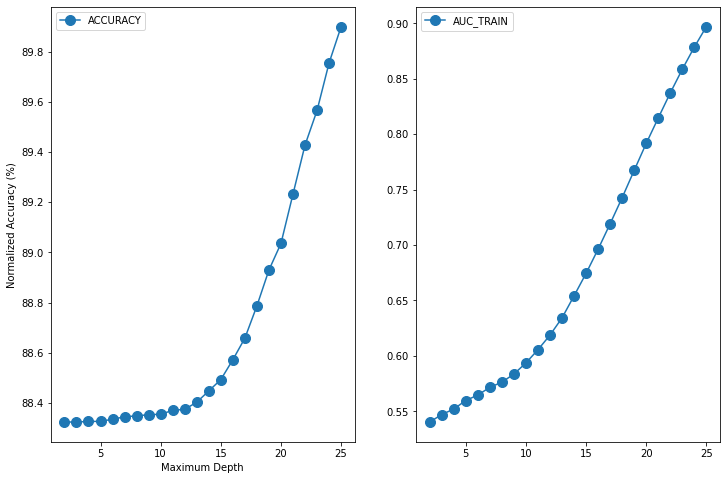

In [23]:
fig_1 = plt.figure(figsize=(12,8))

fig_1_a = plt.subplot(121)
ax1 = performance_df.plot(x = 'MAX_DEPTH', y = 'ACCURACY', ax = fig_1_a, style = 'o-', markersize =10)
ax1.set_ylabel("Normalized Accuracy (%)")
ax1.set_xlabel("Maximum Depth")

fig_1_b = plt.subplot(122)
ax2 = performance_df.plot(x = 'MAX_DEPTH', y = 'AUC_TRAIN', ax = fig_1_b, style = 'o-', markersize =10)
ax2 = performance_df.plot(x = 'MAX_DEPTH', y = 'AUC_TEST', ax = fig_1_b, style = 'o-', markersize =10)
ax2.set_xlabel("Maximum Depth")
ax2.set_ylabel("Area Under the Curve (AUC)")

plt.show()

#### Therefore Max Depth 15,  AUC values  fair at ~0.7,accuracy  high too

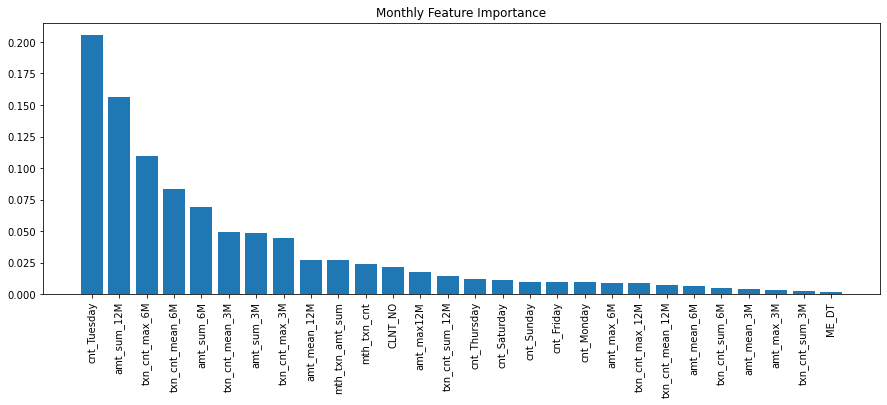

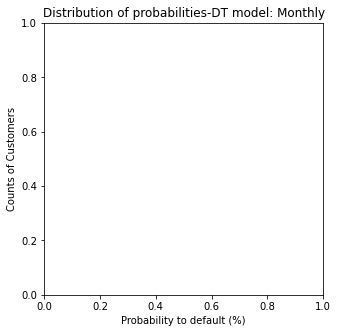

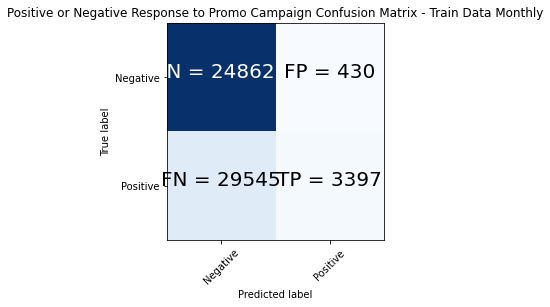

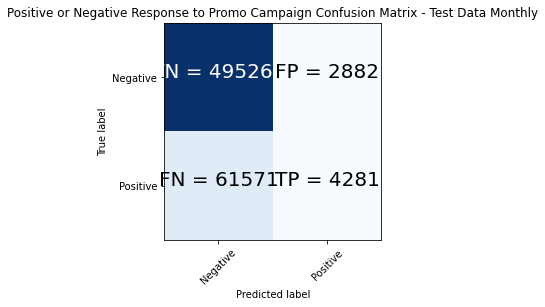

              precision    recall  f1-score   support

    Positive       0.89      0.99      0.94    498148
    Negative       0.60      0.07      0.12     65852

    accuracy                           0.89    564000
   macro avg       0.74      0.53      0.53    564000
weighted avg       0.86      0.89      0.84    564000



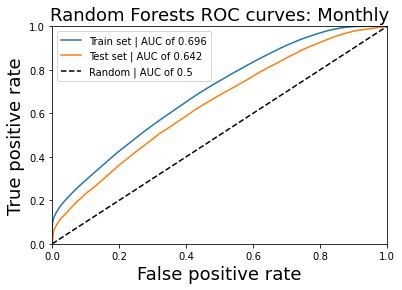

In [24]:
                                                   #Fitting model 
# Define and fit
estimator = DecisionTreeClassifier(random_state=0, max_depth = 15)
dtc_best_model = estimator.fit(X_train_monthly, y_train_monthly)
scores_train = dtc_best_model.predict_proba(X_train_monthly)[:,1] 
scores_test  = dtc_best_model.predict_proba(X_test_monthly)[:,1]  

# Predict the class of test set
y_test_predicted = dtc_best_model.predict(X_test_monthly)
y_train_predicted = dtc_best_model.predict(X_train_monthly)
                                         
accuracy = 100*accuracy_score(y_test_monthly, y_test_predicted, normalize = True)
                                         
# ROC Calc 
fpr_train, tpr_train, _ = roc_curve(y_train_monthly, scores_train)
fpr_test, tpr_test, _ = roc_curve(y_test_monthly, scores_test)
                                         
# Calculate the AUCs
auc_train = auc(fpr_train, tpr_train)
auc_test  = auc(fpr_test, tpr_test)
    
    
    
    
    
 #2.5 Plotting coefficient values or feature importance
        
        
importances =dtc_best_model.feature_importances_
# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [monthly_features_outputs.columns[i] for i in indices] 

# Create plot
plt.figure(figsize=(15,5))
# Create plot title
plt.title("Monthly Feature Importance")
# Add bars
plt.bar(range(X_monthly.shape[1]), importances[indices])
# Add feature names as x-axis labels
plt.xticks(range(X_monthly.shape[1]), names, rotation=90)
# Show plot
plt.show()




# 2.6 Plotting probability distribution for test set.
    


plt.figure(figsize=(5,5))
#sns.displot(data = scores_test, x = 100*scores_test)
plt.title('Distribution of probabilities-DT model: Monthly')
plt.xlabel('Probability to default (%)')
plt.ylabel('Counts of Customers')
plt.show()





# 2.7 Plotting confusion matrix and ROC curves of train/test set & Calculating precision/recall.

# Confusion matrix :Train
cm= confusion_matrix(y_train_monthly, y_train_predicted)
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
classNames = ['Negative','Positive']
plt.title('Positive or Negative Response to Promo Campaign Confusion Matrix - Train Data Monthly')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
thresh = cm.max() / 2.
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.show()


# Confusion matrix : Test
cm= confusion_matrix(y_test_monthly, y_test_predicted)
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
classNames = ['Negative','Positive']
plt.title('Positive or Negative Response to Promo Campaign Confusion Matrix - Test Data Monthly')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
thresh = cm.max() / 2.
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.show()


# Precision and Recall
print(classification_report(y_test_monthly, y_test_predicted, target_names = ['Positive', 'Negative']))

# ROC Curve
plt.plot(fpr_train, tpr_train, label='Train set | AUC of {:4.3f}'.format(auc_train));
plt.plot(fpr_test, tpr_test, label='Test set | AUC of {:4.3f}'.format(auc_test));
plt.plot([0,1], [0,1], color = 'k', linestyle = '--', label = 'Random | AUC of 0.5');
plt.ylim([0,1.0])
plt.xlim([0,1.0])
plt.title('Random Forests ROC curves: Monthly', fontsize = 18)
plt.ylabel('True positive rate', fontsize = 18)
plt.xlabel('False positive rate', fontsize = 18)
plt.legend()
plt.show()



# # 2.8  Plotting decision boundary for top 2 features.


# # The importances with the highest values are "ann_txn_amt_sum_2012" and "cnt_Tuesday" 

# #Limits: Max @ "txn_cnt_max_6M" :6 and @ "amt_sum_12M" :3
# f1_max = math.ceil(X_train_monthly.max(axis=0)[13] )
# f2_max = math.ceil(X_train_monthly.max(axis=0)[25] )

# # Limits: Min @ "txn_cnt_max_6M": 0 and "cnt_Tuesday": 0
# f1_min = math.floor(X_train_monthly.min(axis=0)[13])
# f2_min = math.floor(X_train_monthly.min(axis=0)[25])


# #Creating a 10x10 grid between the min and max values that we will use to estimate the probabilities for the contour plot.
# xx, yy = np.mgrid[f1_min:f1_max:(f1_max-f1_min)/10, f2_min:f2_max:(f2_max-f2_min)/10] # A 10x10 grid is created
# grid = np.c_[xx.ravel(), yy.ravel()]
# print(grid.shape) # Confirm that grid shape is 10x10

# # np.ones is a table full of ones with 100x28 dimension
# # np.median calculates the median of every column in the X_train along axis=0 (i.e. column)
# median_inputs = np.ones((100, 28)) * np.median(X_train_monthly, axis=0) 
# pd.DataFrame(median_inputs) # Convert to pandas is not necessary. Just doing it here to have a nice view of the table

# # Then, we replace the 39th and 68th column with the values of the grid
# median_inputs[:,13] = grid[:,0]
# median_inputs[:,25] = grid[:,1]
# df = pd.DataFrame(median_inputs).iloc[:12,10:26] # Convert to pandas is not necessary. 
# df.style.apply(lambda x: ['background: grey' if (x.name == 13)|(x.name == 25)  else '' for i in x])

# probs =  dtc_best_model.predict_proba(median_inputs)[:, 1].reshape(xx.shape)

# f, ax = plt.subplots(figsize=(8, 6))
# contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
#                       vmin=0, vmax=1)
# ax_c = f.colorbar(contour)
# ax_c.set_label("$P(y = 1)$")
# #ax_c.set_ticks([0, .25, .5, .75, 1])

# ax.scatter(X_train_monthly[:,13], X_train_monthly[:, 25], c=y_train_monthly, s=50,cmap="RdBu", vmin=-.2, vmax=1.2,
#            edgecolor="white", linewidth=1)

# ax.set(aspect="auto",
#        xlim=(0, 5.4), ylim=(0, 2.5),
#        xlabel="txn_cnt_mean_6M", ylabel="cnt_Tuesday")
    
# plt.show()  
  



### <span style='color:Green'> Method 3 : Random Forests  </span>

####  <span style='color:Blue'> Annual data </span> 

In [25]:
#2.4 Fitting the training dataset and optimize the hyperparameters of the method
    
# Initiate some parameters that to track in the iteration below
max_depth_range = range(1, 12)
estimator_max_depth = []
accuracy_normalized = []
auc_train           = []
auc_test            = []

for i in max_depth_range:
    # Define and fit
    estimator_max_depth.append(RandomForestClassifier(random_state=0, max_depth = i))
    estimator_max_depth[i-1].fit(X_train_annual, y_train_annual)
    # Score train and test set,we don't need to store this in every iteration so we can overwrite it 
    scores_train = estimator_max_depth[i-1].predict_proba(X_train_annual)[:,1] 
    scores_test  = estimator_max_depth[i-1].predict_proba(X_test_annual)[:,1]  
    # Predict the class of test set
    y_test_predicted_annual = estimator_max_depth[i-1].predict(X_test_annual)
    # Calculate accuracy at every iteration and append
    accuracy_normalized.append(100*accuracy_score(y_test_annual, y_test_predicted_annual, normalize = True))
    # ROC Calc Train set,we don't need to store this in every iteration so we can overwrite it
    fpr_train, tpr_train, _ = roc_curve(y_train_annual, scores_train)
    # ROC Calc Test set,we don't need to store this in every iteration so we can overwrite it
    fpr_test, tpr_test, _ = roc_curve(y_test_annual, scores_test)
    # Calculate the AUCs
    auc_train.append(auc(fpr_train, tpr_train))
    auc_test.append(auc(fpr_test, tpr_test))
    
    
performance_dictionary = {'ACCURACY': accuracy_normalized, 
                          'AUC_TRAIN': auc_train,
                          'AUC_TEST': auc_test}
performance_df = pd.DataFrame(performance_dictionary)
performance_df['MAX_DEPTH'] = performance_df.index + 2
performance_df



,ACCURACY,AUC_TRAIN,AUC_TEST,MAX_DEPTH
0,90.174292,0.780877,0.738981,2
1,90.174292,0.811854,0.749968,3
2,90.174292,0.848123,0.746111,4
3,90.174292,0.894017,0.749993,5
4,90.174292,0.941769,0.741178,6
5,90.174292,0.976661,0.735864,7
6,90.174292,0.992595,0.735410,8
7,90.174292,0.998196,0.729324,9
8,90.196078,0.999774,0.730065,10
9,90.196078,0.999993,0.723313,11


AttributeError: 'SubplotSpec' object has no attribute 'is_first_col'

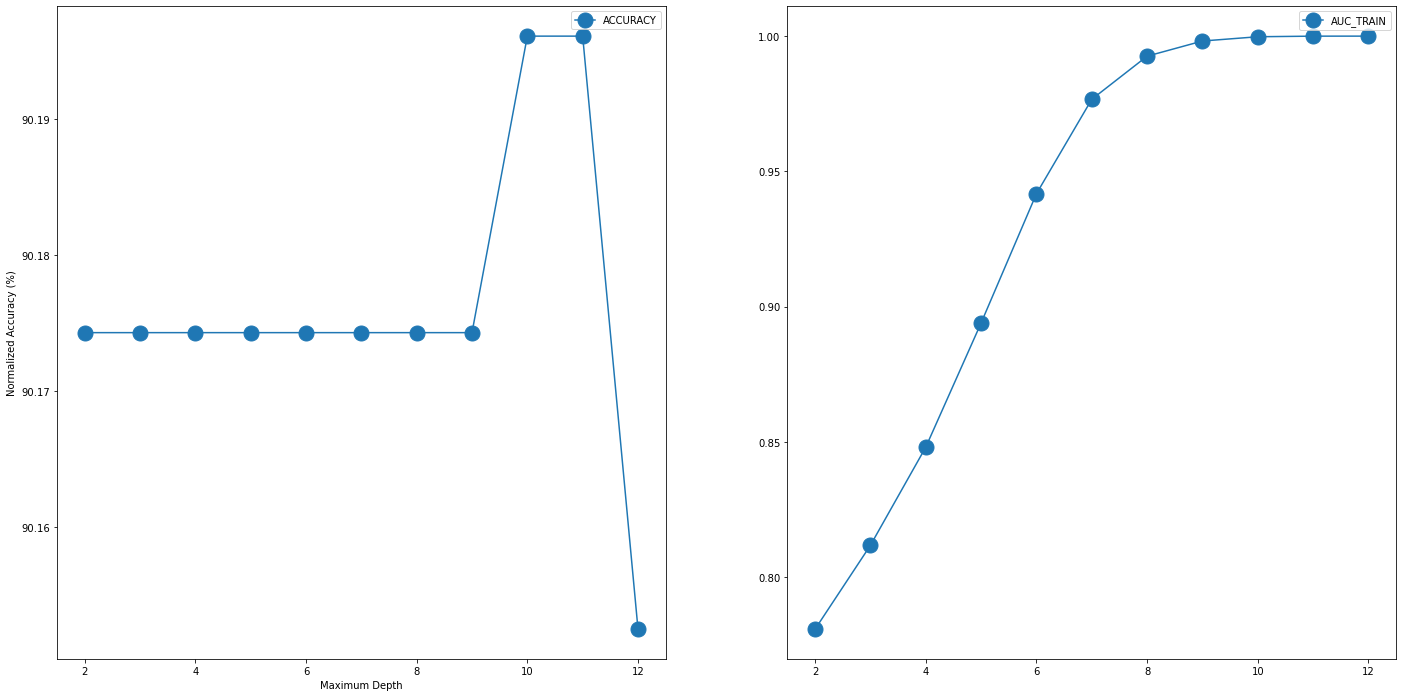

In [26]:
fig_1 = plt.figure(figsize=(24,12))

fig_1_a = plt.subplot(121)
ax1 = performance_df.plot(x = 'MAX_DEPTH', y = 'ACCURACY', ax = fig_1_a, style = 'o-', markersize =15)
ax1.set_ylabel("Normalized Accuracy (%)")
ax1.set_xlabel("Maximum Depth")

fig_1_b = plt.subplot(122)
ax2 = performance_df.plot(x = 'MAX_DEPTH', y = 'AUC_TRAIN', ax = fig_1_b, style = 'o-', markersize =15)
ax2 = performance_df.plot(x = 'MAX_DEPTH', y = 'AUC_TEST', ax = fig_1_b, style = 'o-', markersize =15)
ax2.set_xlabel("Maximum Depth")
ax2.set_ylabel("Area Under the Curve (AUC)")

plt.show()

#### Therefore Max Depth = 3, Accuracy, AUC train and test high  and difference between AUC train and test minimized

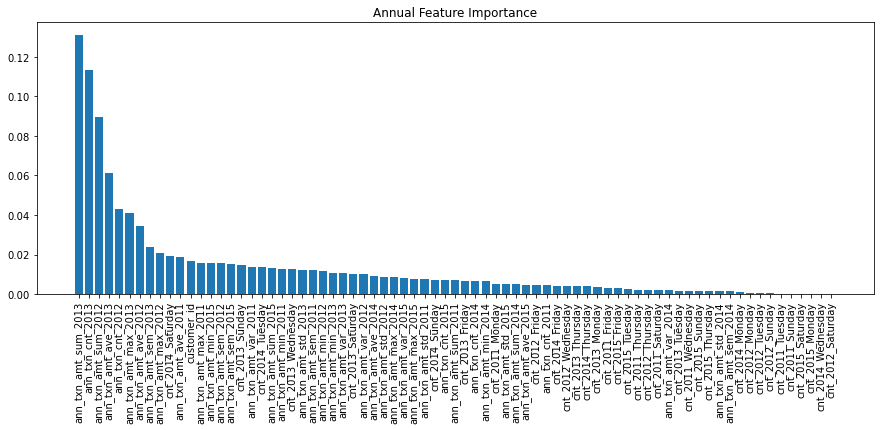

<Figure size 360x360 with 0 Axes>

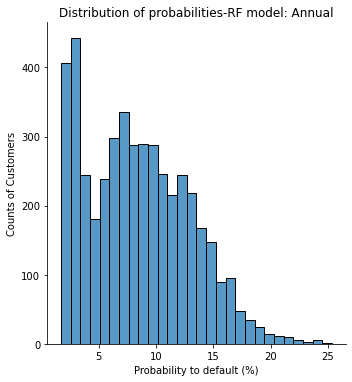

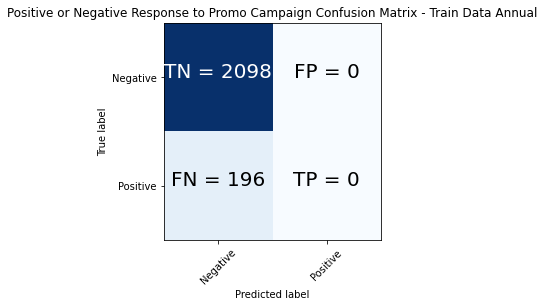

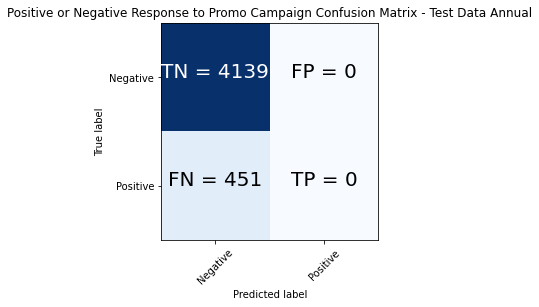

/Users/portiamasibi/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/portiamasibi/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/portiamasibi/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

              precision    recall  f1-score   support

    Positive       0.90      1.00      0.95      4139
    Negative       0.00      0.00      0.00       451

    accuracy                           0.90      4590
   macro avg       0.45      0.50      0.47      4590
weighted avg       0.81      0.90      0.86      4590



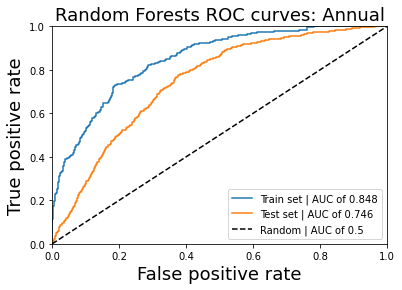

In [28]:
#Fitting model 

# Define and fit
estimator = RandomForestClassifier(random_state=0, max_depth = 3)
dtc_best_model = estimator.fit(X_train_annual, y_train_annual)
scores_train = dtc_best_model.predict_proba(X_train_annual)[:,1] 
scores_test  = dtc_best_model.predict_proba(X_test_annual)[:,1]  

# Predict the class of test set
y_test_predicted = dtc_best_model.predict(X_test_annual)
y_train_predicted = dtc_best_model.predict(X_train_annual)
                                         
accuracy = 100*accuracy_score(y_test_annual, y_test_predicted, normalize = True)
                                         
# ROC Calc 
fpr_train, tpr_train, _ = roc_curve(y_train_annual, scores_train)
fpr_test, tpr_test, _ = roc_curve(y_test_annual, scores_test)
                                         
# Calculate the AUCs
auc_train = auc(fpr_train, tpr_train)
auc_test  = auc(fpr_test, tpr_test)



    
# 2.5 Plotting coefficient values or feature importance
        
importances = dtc_best_model.feature_importances_
# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [annual_features_outputs.columns[i] for i in indices] 

# Create plot
plt.figure(figsize=(15,5))
# Create plot title
plt.title("Annual Feature Importance")
# Add bars
plt.bar(range(X_annual.shape[1]), importances[indices])
# Add feature names as x-axis labels
plt.xticks(range(X_annual.shape[1]), names, rotation=90)
# Show plot
plt.show()



# 2.6 Plotting probability distribution for test set.

plt.figure(figsize=(5,5))
sns.displot(data = scores_test, x = 100*scores_test)
plt.title('Distribution of probabilities-RF model: Annual')
plt.xlabel('Probability to default (%)')
plt.ylabel('Counts of Customers')
plt.show()




# 2.7 Plotting confusion matrix and ROC curves of train/test set & Calculating precision/recall.

# Confusion matrix :Train
cm= confusion_matrix(y_train_annual, y_train_predicted)
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
classNames = ['Negative','Positive']
plt.title('Positive or Negative Response to Promo Campaign Confusion Matrix - Train Data Annual')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
thresh = cm.max() / 2.
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.show()


# Confusion matrix :Test
cm= confusion_matrix(y_test_annual, y_test_predicted)
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
classNames = ['Negative','Positive']
plt.title('Positive or Negative Response to Promo Campaign Confusion Matrix - Test Data Annual')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
thresh = cm.max() / 2.
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.show()


# Precision and Recall
print(classification_report(y_test_annual, y_test_predicted, target_names = ['Positive', 'Negative']))

# ROC Curve
plt.plot(fpr_train, tpr_train, label='Train set | AUC of {:4.3f}'.format(auc_train));
plt.plot(fpr_test, tpr_test, label='Test set | AUC of {:4.3f}'.format(auc_test));
plt.plot([0,1], [0,1], color = 'k', linestyle = '--', label = 'Random | AUC of 0.5');
plt.ylim([0,1.0])
plt.xlim([0,1.0])
plt.title('Random Forests ROC curves: Annual', fontsize = 18)
plt.ylabel('True positive rate', fontsize = 18)
plt.xlabel('False positive rate', fontsize = 18)
plt.legend()
plt.show()



# # 2.8  Plotting decision boundary for top 2 features.


# # The importances with the highest values are "ann_txn_amt_sum_2013" and "ann_txn_cnt_2013 " 

# # Limits: Max @ "ann_txn_amt_sum_2013": 1317 and "ann_txn_cnt_2013 : 17" 

# f1_max = math.ceil(X_train_annual.max(axis=0)[2] )
# f2_max = math.ceil(X_train_annual.max(axis=0)[37] )

# # Limits: Min @ "ann_txn_amt_sum_2013": 0 and "ann_txn_cnt_2013 : 0" 
# f1_min = math.floor(X_train_annual.min(axis=0)[2])
# f2_min = math.floor(X_train_annual.min(axis=0)[37])


# #Creating a 10x10 grid between the min and max values that we will use to estimate the probabilities for the contour plot.
# xx, yy = np.mgrid[f1_min:f1_max:(f1_max-f1_min)/10, f2_min:f2_max:(f2_max-f2_min)/10] # A 10x10 grid is created
# grid = np.c_[xx.ravel(), yy.ravel()]
# print(grid.shape) # Confirm that grid shape is 10x10

# # np.ones is a table full of ones with 100x75 dimension
# # np.median calculates the median of every column in the X_train along axis=0 (i.e. column)
# median_inputs = np.ones((100, 75)) * np.median(X_train_annual, axis=0) 
# pd.DataFrame(median_inputs) # Convert to pandas is not necessary. Just doing it here to have a nice view of the table

# # Then, we replace the 39th and 68th column with the values of the grid
# median_inputs[:,2] = grid[:,0]
# median_inputs[:,37] = grid[:,1]
# df = pd.DataFrame(median_inputs).iloc[:12,0:40] # Convert to pandas is not necessary. 
# df.style.apply(lambda x: ['background: grey' if (x.name == 2)|(x.name == 37)  else '' for i in x])

# probs =  dtc_best_model.predict_proba(median_inputs)[:, 1].reshape(xx.shape)

# f, ax = plt.subplots(figsize=(8, 6))
# contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
#                       vmin=0, vmax=1)
# ax_c = f.colorbar(contour)
# ax_c.set_label("$P(y = 1)$")
# #ax_c.set_ticks([0, .25, .5, .75, 1])

# ax.scatter(X_train_annual[:,2], X_train_annual[:, 37], c=y_train_annual, s=50,cmap="RdBu", vmin=-.2, vmax=1.2,
#            edgecolor="white", linewidth=1)

# ax.set(aspect="auto",
#        xlim=(0, 1150), ylim=(0, 15),
#        xlabel="ann_txn_amt_sum_2013", ylabel="ann_txn_cnt_2013 ")
    
# plt.show() 


####  <span style='color:Blue'> Monthly data </span> 

In [ ]:

#2.4 Fitting the training dataset and optimize the hyperparameters of the method
    
# Initiate some parameters that to track in the iteration below
max_depth_range = range(1, 20)
estimator_max_depth = []
accuracy_normalized = []
auc_train           = []
auc_test            = []

for i in max_depth_range:
    # Define and fit
    estimator_max_depth.append(RandomForestClassifier(random_state=0, max_depth = i))
    estimator_max_depth[i-1].fit(X_train_monthly, y_train_monthly)
    # Score train and test set,we don't need to store this in every iteration so we can overwrite it 
    scores_train = estimator_max_depth[i-1].predict_proba(X_train_monthly)[:,1] 
    scores_test  = estimator_max_depth[i-1].predict_proba(X_test_monthly)[:,1]  
    # Predict the class of test set
    y_test_predicted_monthly = estimator_max_depth[i-1].predict(X_test_monthly)
    # Calculate accuracy at every iteration and append
    accuracy_normalized.append(100*accuracy_score(y_test_monthly, y_test_predicted_monthly, normalize = True))
    # ROC Calc Train set,we don't need to store this in every iteration so we can overwrite it
    fpr_train, tpr_train, _ = roc_curve(y_train_monthly, scores_train)
    # ROC Calc Test set,we don't need to store this in every iteration so we can overwrite it
    fpr_test, tpr_test, _ = roc_curve(y_test_monthly, scores_test)
    # Calculate the AUCs
    auc_train.append(auc(fpr_train, tpr_train))
    auc_test.append(auc(fpr_test, tpr_test))
    
    
performance_dictionary = {'ACCURACY': accuracy_normalized, 
                          'AUC_TRAIN': auc_train,
                          'AUC_TEST': auc_test}
performance_df = pd.DataFrame(performance_dictionary)
performance_df['MAX_DEPTH'] = performance_df.index + 2
performance_df



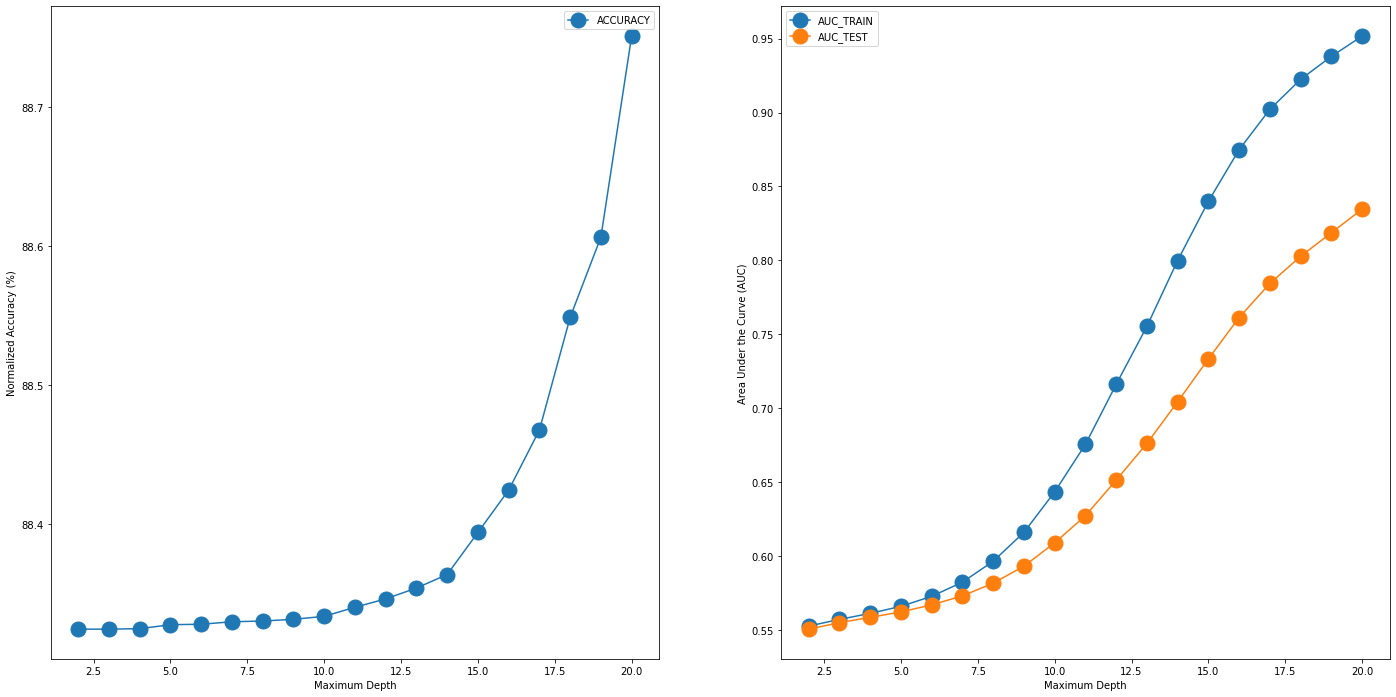

In [ ]:
fig_1 = plt.figure(figsize=(24,12))

fig_1_a = plt.subplot(121)
ax1 = performance_df.plot(x = 'MAX_DEPTH', y = 'ACCURACY', ax = fig_1_a, style = 'o-', markersize =15)
ax1.set_ylabel("Normalized Accuracy (%)")
ax1.set_xlabel("Maximum Depth")

fig_1_b = plt.subplot(122)
ax2 = performance_df.plot(x = 'MAX_DEPTH', y = 'AUC_TRAIN', ax = fig_1_b, style = 'o-', markersize =15)
ax2 = performance_df.plot(x = 'MAX_DEPTH', y = 'AUC_TEST', ax = fig_1_b, style = 'o-', markersize =15)
ax2.set_xlabel("Maximum Depth")
ax2.set_ylabel("Area Under the Curve (AUC)")

plt.show()

#### Therefore Max Depth = 10, AUC train ~0.7 which is a fair but not poor model , accuracy high, AUC test always in the 0.6 region 

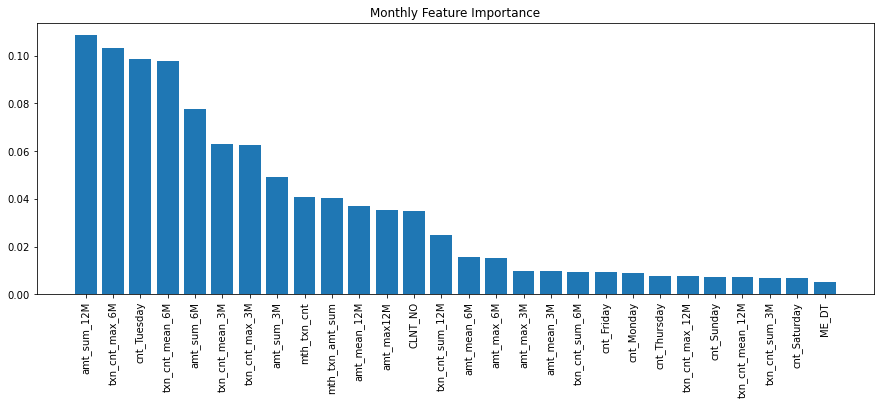

<Figure size 1080x360 with 0 Axes>

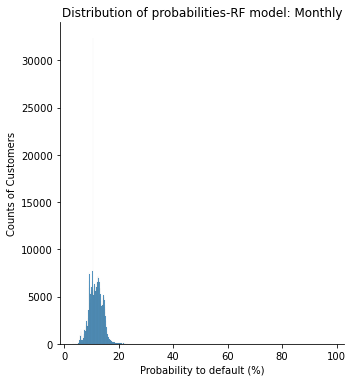

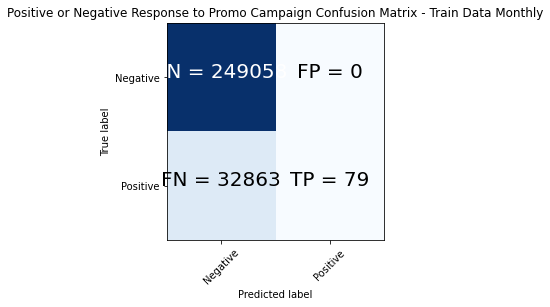

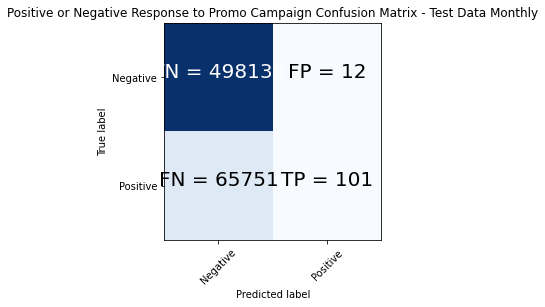

              precision    recall  f1-score   support

    Positive       0.88      1.00      0.94    498148
    Negative       0.89      0.00      0.00     65852

    accuracy                           0.88    564000
   macro avg       0.89      0.50      0.47    564000
weighted avg       0.88      0.88      0.83    564000



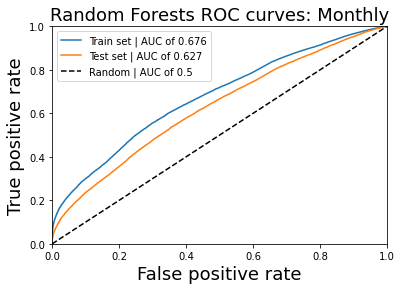

(100, 2)


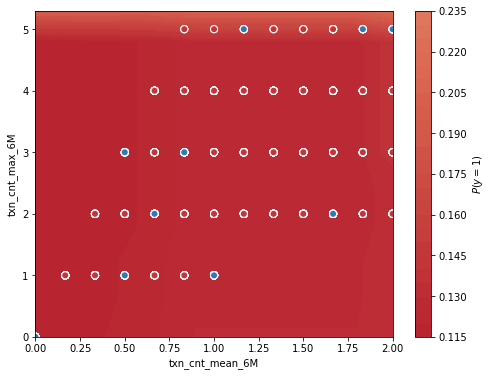

In [ ]:
#Fitting model 
# Define and fit
estimator = RandomForestClassifier(random_state=0, max_depth = 10)
dtc_best_model = estimator.fit(X_train_monthly, y_train_monthly)
scores_train = dtc_best_model.predict_proba(X_train_monthly)[:,1] 
scores_test  = dtc_best_model.predict_proba(X_test_monthly)[:,1]  

# Predict the class of test set
y_test_predicted = dtc_best_model.predict(X_test_monthly)
y_train_predicted = dtc_best_model.predict(X_train_monthly)
                                         
accuracy = 100*accuracy_score(y_test_monthly, y_test_predicted, normalize = True)
                                         
# ROC Calc 
fpr_train, tpr_train, _ = roc_curve(y_train_monthly, scores_train)
fpr_test, tpr_test, _ = roc_curve(y_test_monthly, scores_test)
                                         
# Calculate the AUCs
auc_train = auc(fpr_train, tpr_train)
auc_test  = auc(fpr_test, tpr_test)





 # 2.5 Plotting coefficient values or feature importance
        
importances =dtc_best_model.feature_importances_
# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [monthly_features_outputs.columns[i] for i in indices] 

# Create plot
plt.figure(figsize=(15,5))
# Create plot title
plt.title("Monthly Feature Importance")
# Add bars
plt.bar(range(X_monthly.shape[1]), importances[indices])
# Add feature names as x-axis labels
plt.xticks(range(X_monthly.shape[1]), names, rotation=90)
# Show plot
plt.show()



# 2.6 Plotting probability distribution for test set.

plt.figure(figsize=(15,5))
sns.displot(data = scores_test, x = 100*scores_test)
plt.title('Distribution of probabilities-RF model: Monthly')
plt.xlabel('Probability to default (%)')
plt.ylabel('Counts of Customers')
plt.show()



# 2.7 Plotting confusion matrix and ROC curves of train/test set & Calculating precision/recall.

# Confusion matrix :Train
cm= confusion_matrix(y_train_monthly, y_train_predicted)
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
classNames = ['Negative','Positive']
plt.title('Positive or Negative Response to Promo Campaign Confusion Matrix - Train Data Monthly')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
thresh = cm.max() / 2.
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.show()

# Confusion matrix :Test
cm= confusion_matrix(y_test_monthly, y_test_predicted)
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
classNames = ['Negative','Positive']
plt.title('Positive or Negative Response to Promo Campaign Confusion Matrix - Test Data Monthly')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
thresh = cm.max() / 2.
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.show()


# Precision and Recall
print(classification_report(y_test_monthly, y_test_predicted, target_names = ['Positive', 'Negative']))

# ROC Curve
plt.plot(fpr_train, tpr_train, label='Train set | AUC of {:4.3f}'.format(auc_train));
plt.plot(fpr_test, tpr_test, label='Test set | AUC of {:4.3f}'.format(auc_test));
plt.plot([0,1], [0,1], color = 'k', linestyle = '--', label = 'Random | AUC of 0.5');
plt.ylim([0,1.0])
plt.xlim([0,1.0])
plt.title('Random Forests ROC curves: Monthly', fontsize = 18)
plt.ylabel('True positive rate', fontsize = 18)
plt.xlabel('False positive rate', fontsize = 18)
plt.legend()
plt.show()




# # 2.8  Plotting decision boundary for top 2 features.


# # The importances with the highest values are "txn_cnt_mean_6M" and "txn_cnt_max_6M " 

# #Limits: Max @ "txn_cnt_mean_6M" :2.17 and @ "txn_cnt_max_6M" :6
# f1_max = math.ceil(X_train_monthly.max(axis=0)[12] )
# f2_max = math.ceil(X_train_monthly.max(axis=0)[13] )

# # Limits: Min @ "txn_cnt_mean_6M": 0 and "txn_cnt_max_6M": 0
# f1_min = math.floor(X_train_monthly.min(axis=0)[12])
# f2_min = math.floor(X_train_monthly.min(axis=0)[13])


# #Creating a 10x10 grid between the min and max values that we will use to estimate the probabilities for the contour plot.
# xx, yy = np.mgrid[f1_min:f1_max:(f1_max-f1_min)/10, f2_min:f2_max:(f2_max-f2_min)/10] # A 10x10 grid is created
# grid = np.c_[xx.ravel(), yy.ravel()]
# print(grid.shape) # Confirm that grid shape is 10x10

# # np.ones is a table full of ones with 100x28 dimension
# # np.median calculates the median of every column in the X_train along axis=0 (i.e. column)
# median_inputs = np.ones((100, 28)) * np.median(X_train_monthly, axis=0) 
# pd.DataFrame(median_inputs) # Convert to pandas is not necessary. Just doing it here to have a nice view of the table

# # Then, we replace the 39th and 68th column with the values of the grid
# median_inputs[:,12] = grid[:,0]
# median_inputs[:,13] = grid[:,1]
# df = pd.DataFrame(median_inputs).iloc[:12,10:15] # Convert to pandas is not necessary. 
# df.style.apply(lambda x: ['background: grey' if (x.name == 12)|(x.name == 13)  else '' for i in x])

# probs =  dtc_best_model.predict_proba(median_inputs)[:, 1].reshape(xx.shape)

# f, ax = plt.subplots(figsize=(8, 6))
# contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
#                       vmin=0, vmax=1)
# ax_c = f.colorbar(contour)
# ax_c.set_label("$P(y = 1)$")
# #x_c.set_ticks([0, .25, .5, .75, 1])

# ax.scatter(X_train_monthly[:,12], X_train_monthly[:, 13], c=y_train_monthly, s=50,cmap="RdBu", vmin=-.2, vmax=1.2,
#            edgecolor="white", linewidth=1)

# ax.set(aspect="auto",
#        xlim=(0, 2 ), ylim=(0, 5.3),
#        xlabel="txn_cnt_mean_6M", ylabel="txn_cnt_max_6M")
# plt.show()




## <span style='color:Orange'> 3. Comparison of methods </span>

#### The Results are Summarised Below:


|     | Yearly    |      |     |                                             
| :--- | :---:      |:---:    |:---:   |
|Model|Logistic Reg|Decision Tree| Random Forest| 
|Hyperparameter| C = 1|max_depth = 4| max_depth = 2| 
|AUC Train|0.604 |0.792|0.848|
|AUC Test| 0.548|0.722|0.746|
|Precision:Positive| 0.90| 0.91 |0.90|
|Precision:Negative| 0.00 | 0.34|0.00|
|Recall:Positive|1.00  | 0.98|1.00|
|Recall:Negative| 0.00 |0.08 |0.00|
|Accuracy|0.90 |  0.89|0.90|0.91 |0.90|0.91 |
|Test:True Positive|0 |35|0|
|Test:False Positive|0 |68|0|
|Test:True Negative| 4139|4071|4139|
|Test:False Negative|451 |416|451|
|Train:True Positive|0 |45|0| 0|1158| 16|
|Train:False Positive| 0|18|0|
|Train:True Negative|2098 |2080|4139|
|Train:False Negative| 196|151|451|


| |Monthly| | | 
|:---:   |:---: |:---: |:---: |
|Model| Logistic Reg |Decision Train| Random Forest|
|Hyperparameter| C = 1|max_depth = 15| max_depth = 10|
|AUC Train| 0.420 |0.753|0.754 |
|AUC Test |0.422 |0.624|0.653 |
|Precision:Positive| 0.91|0.91| 0.91|
|Precision:Negative| 0.00 |0.18|0.00 |
|Recall:Positive|1.00 |0.99| 1.00|
|Recall:Negative|0.00 |0.02| 0.00|
|Accuracy|0.91 |0.90|0.91 |
|Test:True Positive|0 |487| 0|
|Test:False Positive|0 |2173|0 |
|Test:True Negative| 19539|19322| 19539|
|Test:False Negative|20302 |19815|20302 |
|Train:True Positive| 0|99|0 |
|Train:False Positive| 97742|97643| 97742|
|Train:False Negative|10107 |8949|10091 |


|     | Yearly    |      |     |                                           
| :--- | :---:      |:---:    |:---:   |
|Model|Logistic Reg|Decision Tree| Random Forest| 
|ROC Curves|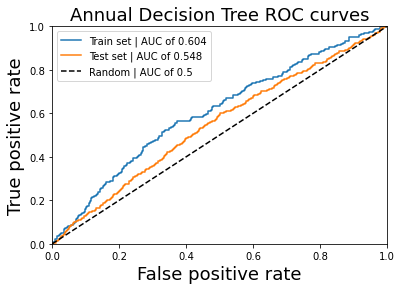 |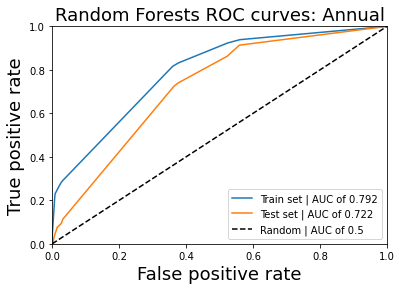|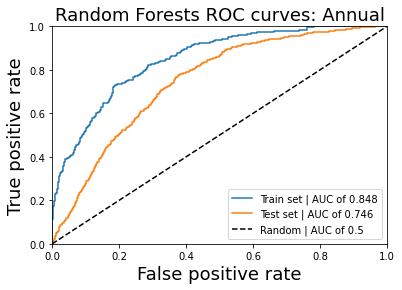|![image-11.png](attachment:image-11.png) |
|Decision Boundary Fig|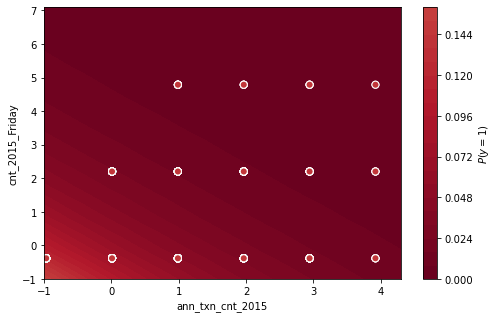 |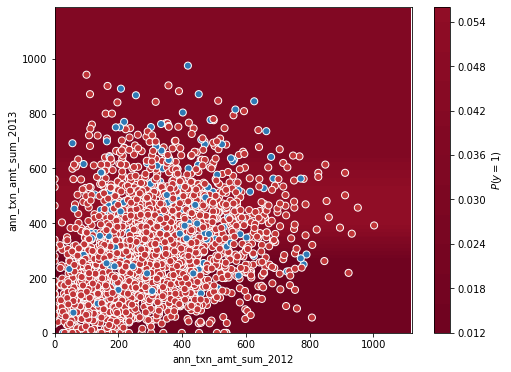|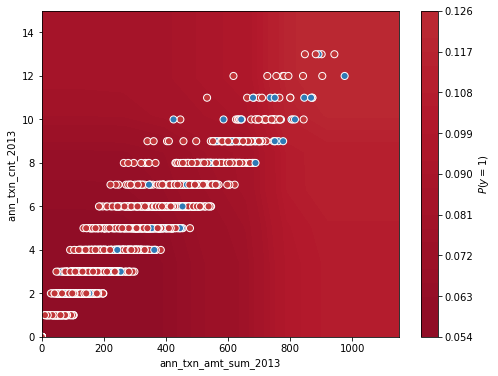|![image-2.png](attachment:image-2.png) |


| | Monthly| | | 
| :--- | :---:      |:---:    |:---:   |
|Model|Logistic Reg |Decision Train| Random Forest|
|ROC Curves| 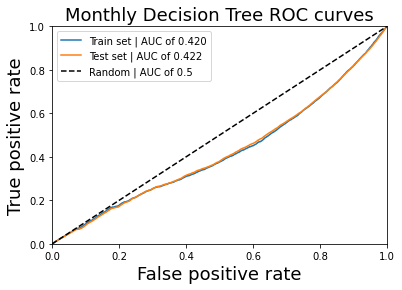|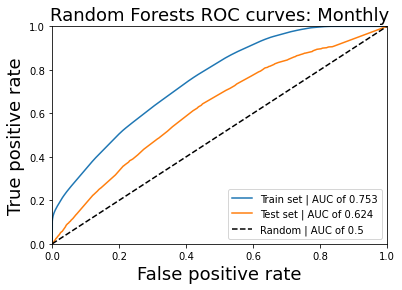|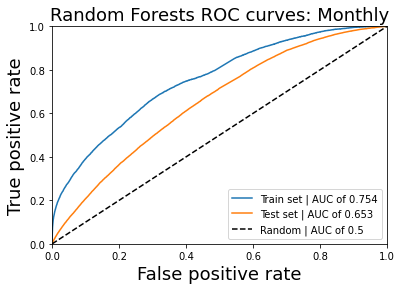|
|Decision Boundary Fig|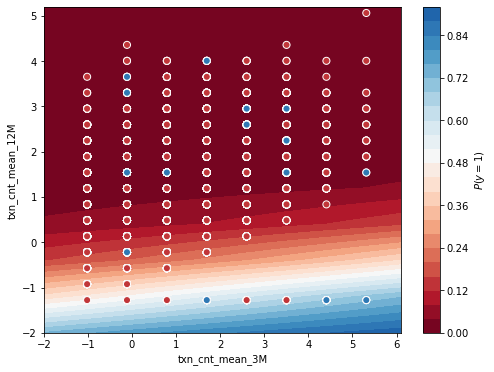|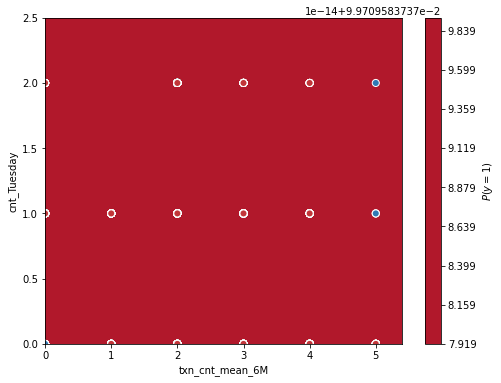|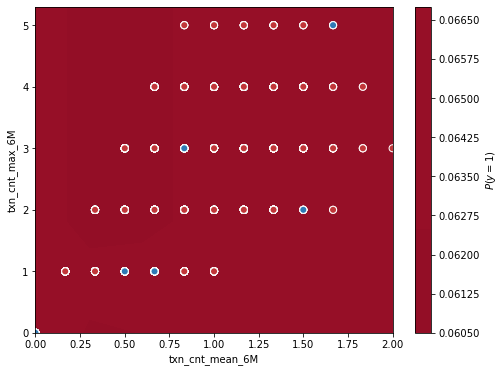|


### To better understand  Confusion Matrix :
    

True Positive, TP: Predicted a positive and it’s true.

True Negative, TN: Predicted negative and it’s true.

False Positive (Type 1 Error), FP: Predicted positive and it’s false.

False Negative (Type 2 Error), FN: Predicted negative and it’s false.

When taking a look at annual data, first a look at the responses in the test data

In [2]:
#y_test_annual
#a = pd.DataFrame(y_test_annual, columns = ['response'])
#a ['response'].value_counts()

The logistic regression and random forest perform similarly as they both predict up to 90% accuracy, the TN match initial responses from test data and the positive responses are unfortunetely interpreted as negatives, therefore FN.The decision tree model is however able to capture some of the positive responses with a high TP and high TN value and an accuracy of 89%. Therefore for a trade of 1% in accuracy, the Decision Tree model is preferred as it can capture most TP and TN values. 

The same conclusion is reached for monthly data based on confusion matrix and accuracy. 

For precision and accuracy, the results also show us decision tree is much better with a higher precision and recall value.

Now as we have decided to go ahead with the Decision Tree, now to decide on Monthly VS Anuual Data, for this we use the ROC Curves and the Decision Boundaries, The Train AUC and Test AUC of the Annual data is generally higher, but it has to be taken into consideration that the monthly data has more TP and TN values.

From the Decision Boundary, although there is no exact boundary, we can see that some of the data in the monthly annual figure have positive responses, it makes sense as for an unbalanced dataset such as this one, there are very few positive responses and not a clear boundary/ classification/cluster therefore for a model to be able to pick those is very good. 

### Answer : Random Forest with Monthly Data